# Imports

In [1]:
import pyxdf
import time
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import wave
#import pyaudio
import numpy as np
import sounddevice as sd
import cv2
from scipy.signal import iirnotch, filtfilt
from glob import glob
from tqdm import tqdm
from datetime import date, datetime
import calendar
from fpdf import FPDF


In [2]:
xdf_path = "../Data/real_subjects/sub-P5318014/sub-P5318014_ses-S001_task-CUNY_run-001_mobi.xdf"
data, header = pyxdf.load_xdf(xdf_path)
streams_collected = [stream['info']['name'][0] for stream in data]


'''
HELPERS
'''
def get_event_data(event, df, stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]

def get_secs_between_triggers(trigger1, trigger2, stim_df):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

                  
streams_collected

['WebcamStream',
 'Tobii',
 'Stimuli_Markers',
 'OpenSignals',
 'EGI NetAmp 0',
 'Microphone']

In [9]:
# get the date collected
x = time.time()
# convert x to datetime
date = datetime.utcfromtimestamp(float(data[0]['info']['created_at'][0])).strftime('%m-%d-%Y %H:%M')
date


/var/folders/xf/yrxhv1td653c13cnbnjmybcr0000gq/T/ipykernel_53822/3354551815.py:4: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  date = datetime.utcfromtimestamp(float(data[0]['info']['created_at'][0])).strftime('%m-%d-%Y %H:%M')


'01-21-1970 06:33'

# Stimulus

In [3]:
stim_dat = data[streams_collected.index('Stimuli_Markers')]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)
events = {
    200: 'Onset_Experiment',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_Experiment',
}

story_onsets = [20, 30, 40, 50, 60, 70]

# relabel the event if the trigger is in the events dictionary, else if 
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')

# relabel the event as a psychopy timestamp if the trigger is greater than 5 digits
stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
stim_df['time'] = (stim_dat['time_stamps'] - stim_dat['time_stamps'][0])/1000
stim_df

,trigger,event,lsl_time_stamp,time
0,200,Onset_Experiment,737702.874688,0.000000e+00
1,1729193598,psychopy_time_stamp,737702.874699,1.029996e-08
2,10,Onset_RestingState,737715.257669,1.238298e-02
3,1729193610,psychopy_time_stamp,737715.257678,1.238299e-02
4,11,Offset_RestingState,738015.257488,3.123828e-01
...,...,...,...,...
256,1729195883,psychopy_time_stamp,739988.698994,2.285824e+00
257,201,Offset_Experiment,739993.702234,2.290828e+00
258,1729195888,psychopy_time_stamp,739993.702247,2.290828e+00
259,4,Bx_input,739993.702478,2.290828e+00


# EEG

In [4]:
EEG = data[streams_collected.index('EGI NetAmp 0')]
eeg_dat = pd.DataFrame(EEG['time_series'])
eeg_dat['lsl_time_stamp'] = EEG['time_stamps']

## Plotting Raw Data

Appending the data we care about

In [5]:
blocks = ['RestingState', 'StoryListening', 'SocialTask']
eeg_raw = pd.DataFrame()
for block in blocks:
    block_df = get_event_data(block, eeg_dat, stim_df)
    # append to the eeg_raw dataframe
    eeg_raw = pd.concat([eeg_raw, block_df], axis=0)

In [8]:
rest_eeg = get_event_data('RestingState', eeg_dat, stim_df=stim_df)
fig, ax = plt.subplots(figsize=(12, 6))

for i, channel in enumerate(eeg_raw.columns):
    if channel == 'lsl_time_stamp':
        # skip the time column
        continue
    else:
        plt.plot(eeg_raw['lsl_time_stamp'], eeg_raw[channel], label=f'Channel {i+1}')
        ax.axvline(stim_df.loc[stim_df.event == 'Onset_'+ block, 'lsl_time_stamp'].values[0], color='r')
        ax.axvline(stim_df.loc[stim_df.event == 'Offset_'+ block, 'lsl_time_stamp'].values[0], color='r')

'''
ax.axvline(stim_df.loc[stim_df.event == 'Onset_RestingState', 'lsl_time_stamp'].values[0], color='r')
ax.axvline(stim_df.loc[stim_df.event == 'Offset_RestingState', 'lsl_time_stamp'].values[0], color='r')

ax.axvline(stim_df.loc[stim_df.event == 'Onset_StoryListening', 'lsl_time_stamp'].values[0], color='r')
ax.axvline(stim_df.loc[stim_df.event == 'Offset_StoryListening', 'lsl_time_stamp'].values[0], color='r')

ax.axvline(stim_df.loc[stim_df.event == 'Onset_SocialTask', 'lsl_time_stamp'].values[0], color='r')
ax.axvline(stim_df.loc[stim_df.event == 'Offset_SocialTask', 'lsl_time_stamp'].values[0], color='r')
'''
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Raw Resting State EEG Data')
plt.show()

: 

## Check out variances

In [13]:
# calculate the mean and variance of each channel
means = rest_eeg.mean()
channels  = pd.DataFrame({'channel_mean': rest_eeg.mean(), 'channel_var': rest_eeg.var()})
# create a table that shows the mean and variance of each channel, sorted by variance. Shade the cells based on value
channels.style.background_gradient(cmap='viridis')
channels


,channel_mean,channel_var
0,-8506.293945,3.368462e+05
1,-7982.113281,8.263734e+05
2,-4524.562500,4.625392e+05
3,1862.851685,3.054431e+05
4,-947.784485,1.264369e+05
...,...,...
124,2472.630127,9.461727e+06
125,10863.036133,3.760015e+05
126,-947.572876,3.551468e+05
127,-4445.968750,5.546508e+04


Apply Notch Filter?

In [31]:
# remove the 
rest_times = rest_eeg['lsl_time_stamp']
rest_eeg.drop(columns='lsl_time_stamp', inplace=True)


/var/folders/xf/yrxhv1td653c13cnbnjmybcr0000gq/T/ipykernel_13100/2290600471.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_eeg.drop(columns='lsl_time_stamp', inplace=True)


In [68]:
def apply_notch_filter(data, fs, f0, Q):
    nyquist = 0.5 * fs
    w0 = f0 / nyquist
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, data)

filtered_eeg = rest_eeg.apply(lambda x: apply_notch_filter(x, 1000, 60, 90))

In [35]:
filtered_eeg.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
87927,-6985.257761,-6177.073195,-3213.289113,2855.641072,-216.562797,1164.991297,2224.039747,606.885651,-5008.115773,-4262.689002,...,-4221.721823,-653.122829,-9596.972179,-2752.236055,-2134.288976,1536.895057,6816.194803,12338.954809,277.969645,-4255.180396
87928,-6986.511197,-6179.356588,-3215.930171,2854.683117,-219.801483,1165.127681,2224.158249,604.126286,-5010.371435,-4261.725723,...,-4222.164299,-657.411603,-9601.639142,-2755.028811,-2138.538177,1535.715442,6813.214811,12341.340570,280.853292,-4251.798939
87929,-6989.395239,-6178.407270,-3215.313886,2853.848277,-220.226244,1165.328256,2222.380044,604.508893,-5010.251275,-4264.188767,...,-4219.622514,-655.889500,-9602.768372,-2753.887380,-2137.533663,1533.902109,6814.657415,12343.961292,285.028916,-4251.239967
87930,-6986.591905,-6177.498518,-3213.680863,2856.109053,-219.751089,1162.175832,2222.823694,606.519467,-5008.608736,-4260.321440,...,-4215.895123,-649.474025,-9599.126961,-2751.434946,-2134.607198,1538.448022,6817.034550,12348.067073,285.713039,-4247.427082
87931,-6983.522087,-6177.276551,-3213.956986,2858.286527,-216.922908,1167.635805,2223.503824,606.826560,-5008.781780,-4260.664063,...,-4215.102868,-651.602203,-9598.125375,-2752.537457,-2134.498123,1540.304739,6819.011004,12351.651534,287.373951,-4245.007379


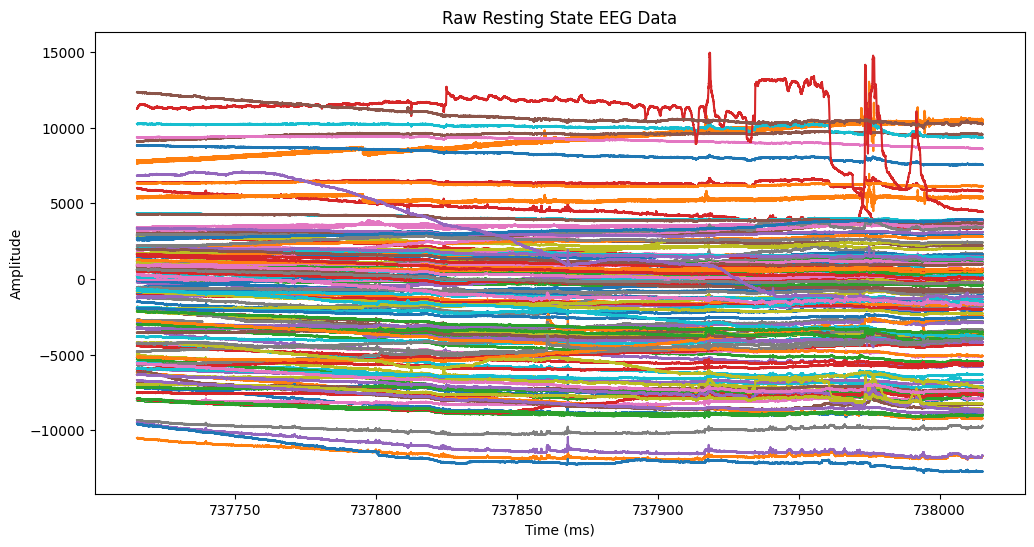

In [36]:
# plot the EEG data
plt.figure(figsize=(12, 6))

for i, channel in enumerate(filtered_eeg.columns):
    
    plt.plot(rest_times, filtered_eeg[channel], label=f'Channel {i+1}')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Raw Resting State EEG Data')
plt.show()

## applying a high pass filter

In [71]:
from scipy.signal import butter, filtfilt
# apply a high pass filter to the data
def apply_high_pass_filter(data, fs, cutoff, order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

filtered_eeg = filtered_eeg.apply(lambda x: apply_high_pass_filter(x, 1000, 1.0, 4))



In [41]:
filtered_eeg.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
87927,0.018273,-0.748997,-2.756076,-1.611206,-1.028094,-0.097813,-0.044266,-1.789187,0.227046,0.661564,...,0.678361,-0.930530,-3.122453,-0.415455,-1.639415,-1.261854,-4.487767,-0.025288,0.088226,-0.553647
87928,-1.241737,-3.046932,-5.409440,-2.601155,-4.283247,0.013942,0.052953,-4.573315,-2.046453,1.599681,...,0.224637,-5.212718,-7.786292,-3.227564,-5.904465,-2.468247,-7.486808,2.347115,2.950702,2.780404
87929,-4.132306,-2.112144,-4.805463,-3.468007,-4.724484,0.189909,-1.746519,-4.215462,-1.944118,-0.888505,...,2.755196,-3.684011,-8.912358,-2.105482,-4.915802,-4.308365,-6.063288,4.954517,7.105199,3.291976
87930,-1.335449,-1.217908,-3.184749,-1.239258,-4.265815,-2.987100,-1.324120,-2.229633,-0.319388,2.953700,...,6.471381,2.738090,-5.267742,0.327608,-2.005193,0.210755,-3.705274,9.047014,7.768240,7.057468
87931,1.727940,-1.010444,-3.473183,0.906172,-1.454127,2.448310,-0.665223,-1.947272,-0.510227,2.585977,...,7.252452,0.616556,-4.262911,-0.794243,-1.911977,2.040670,-1.747978,12.618229,9.408113,9.429788


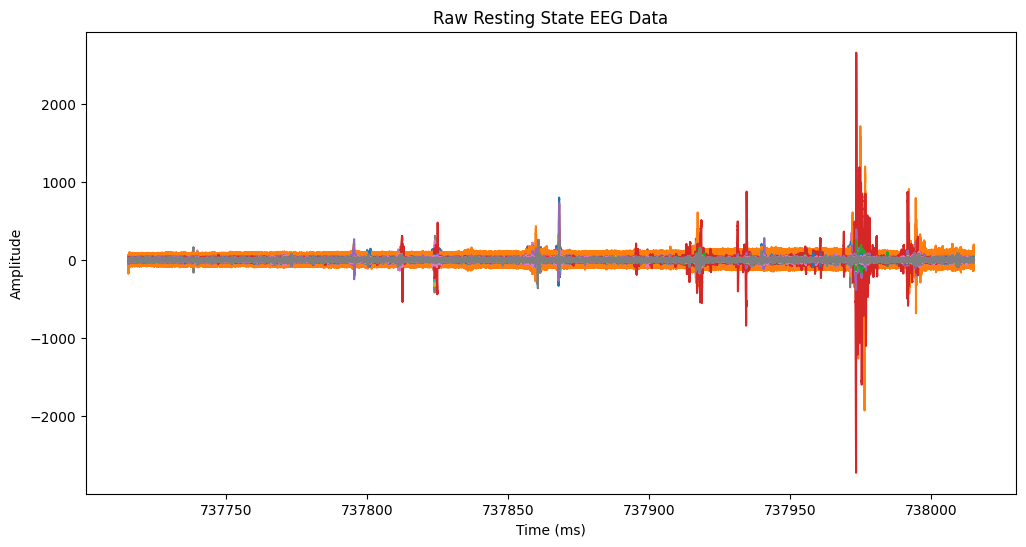

In [39]:
plt.figure(figsize=(12, 6))

for i, channel in enumerate(filtered_eeg.columns):
    
    plt.plot(rest_times, filtered_eeg[channel], label=f'Channel {i+1}')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Raw Resting State EEG Data')
plt.show()

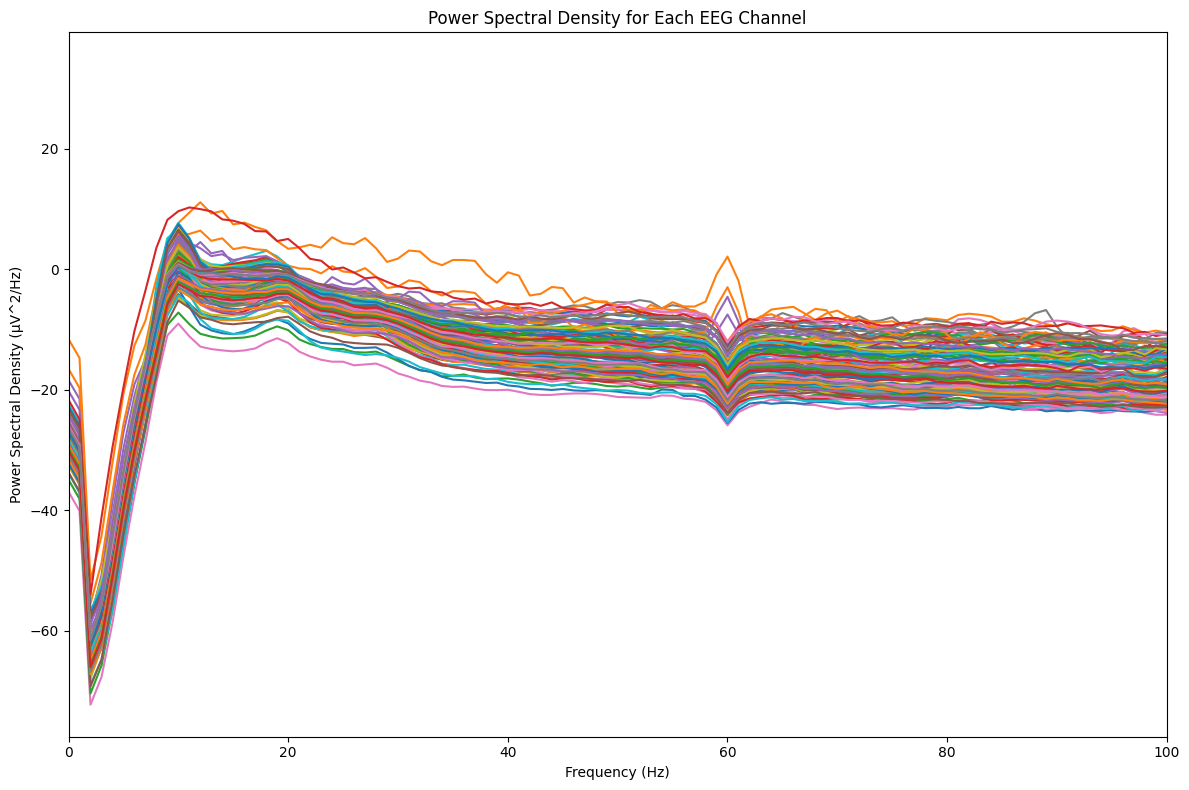

In [70]:
# plot the power spectral density of the EEG data
from scipy.signal import welch

# Sampling frequency in Hz (adjust this to match your EEG sampling rate)
fs = 1000

# Plot power spectral density for each channel
plt.figure(figsize=(12, 8))
for channel in filtered_eeg.columns:
    f, psd = welch(filtered_eeg[channel], fs=fs, nperseg=1000)  # Welch's method
    # take the log of the psd
    psd = 10 * np.log10(psd)
    plt.plot(f, psd, label=channel)
    # limit the x-axis to 100 Hz
    plt.xlim(0, 100)    

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (µV^2/Hz)')
plt.title('Power Spectral Density for Each EEG Channel')
#plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

In [ ]:
rest_eeg = filtered_eeg #eeg_dat[:-1] #get_event_data('RestingState', eeg_dat)
from scipy.signal import spectrogram

plt.figure(figsize=(10, 4))

for column in rest_eeg.columns:
    f, t, Sxx = spectrogram(rest_eeg[column], fs=1000)

    plt.pcolormesh(t, f, 10 *np.log10(Sxx), shading='nearest')

plt.colorbar(label='Power/Frequency [Hz]')
plt.ylabel('Freq')
plt.xlabel('time')
plt.tight_layout()
plt.show()

In [ ]:
from scipy.signal import spectrogram

plt.figure(figsize=(10, 4))

for column in eeg_dat.columns:
    f, t, Sxx = spectrogram(eeg_dat[column], fs=250)

    plt.pcolormesh(t, f, 10 *np.log10(Sxx), shading='nearest')

plt.colorbar(label='Power/Frequency [Hz]')
plt.ylabel('Freq')
plt.xlabel('time')
plt.tight_layout()
plt.show()

In [24]:
eeg_dat = data[streams_collected.index('EGI NetAmp 0')]
eeg_df = pd.DataFrame(eeg_dat['time_series'])
eeg_df['lsl_time_stamp'] = eeg_dat['time_stamps']

eeg_exp = get_event_data('Experiment', eeg_df, stim_df=stim_df)
start = eeg_exp['lsl_time_stamp'].values[0]
stop = eeg_exp['lsl_time_stamp'].values[-1]
eeg_dur = stop - start

# List of variables to include in the DataFrame
dur_variables = ['experiment_dur', 'eyetracking_dur', 'phys_dur', 'cam_dur', 'mic_story_dur', 'story_dur', 'eeg_dur']
variables = {name: globals()[name] for name in dur_variables}

# Convert the dictionary to a pandas DataFrame
durations_df = pd.DataFrame(list(variables.items()), columns=['Variable Name', 'Variable Value'])
durations_df

,Variable Name,Variable Value
0,experiment_dur,1775.846282
1,eyetracking_dur,1775.466180
2,phys_dur,1775.844584
3,cam_dur,1775.498013
4,mic_story_dur,1119.791873
5,story_dur,1139.648473
6,eeg_dur,1775.845401


 Make the pdf

In [16]:
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()
#set font for the title
pdf.set_font("Arial", size=12)
#Title of the document
today = date.today()
today = today.strftime("%B %d, %Y")
pdf.set_fill_color(220, 220, 220)  # RGB values for the color
pdf.cell(180, 10, f"CUNY Data Report, {calendar.day_name[date.today().weekday()]}, {today} ",ln=True, align='C', border=1, fill=True)
pdf.output("output_testfile.pdf")

''